In [108]:
import pandas as pd
import numpy as np
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from tqdm import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [109]:
categories = [0, 1]
newsgroups_train = pd.read_csv("data_train_preprocessed.csv", keep_default_na=False)
newsgroups_test = pd.read_csv("data_test_preprocessed.csv", keep_default_na=False)
class_names = ['Not Harmful', 'Harmful']

Let's use the tfidf vectorizer, commonly used for text.

In [110]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train["processed_text_alt"])
test_vectors = vectorizer.transform(newsgroups_test["processed_text_alt"])

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [149]:
# Define a parameter grid to search over
param_grid = {
    'n_estimators': [500],
    'max_depth': [None, 30],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2', 0.5],  # 'auto' is equivalent to 'sqrt'
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced'],
    # 'criterion': ['gini', 'entropy'],
    # 'min_weight_fraction_leaf': [0.0, 0.1],  # Adding a small non-zero value can help with imbalanced classes
    # 'max_leaf_nodes': [None, 50, 100]  # None means unlimited number of leaf nodes
}

# Calculate the total number of iterations
total_iterations = (len(param_grid['n_estimators']) * 
                    len(param_grid['max_depth']) * 
                    len(param_grid['min_samples_split']) * 
                    len(param_grid['min_samples_leaf']) * 
                    len(param_grid['max_features']) * 
                    len(param_grid['bootstrap']) * 
                    len(param_grid['class_weight']) * 
                    # len(param_grid['criterion']) * 
                    # len(param_grid['min_weight_fraction_leaf']) * 
                    # len(param_grid['max_leaf_nodes']) * 
                    1)  # 5 for the number of folds in cross-validation

# Create a RandomForestClassifier object
rf = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object with the parameter grid and a scoring method, such as 'f1_weighted'
with tqdm(total=total_iterations) as pbar:
    grid_search = GridSearchCV(
        rf, param_grid, cv=5, scoring='f1_weighted', 
        n_jobs=-1, 
        verbose=0,
        pre_dispatch='2*n_jobs'
    )

    # Fit the grid search to the data
    with joblib.parallel_backend('threading', n_jobs=-1):
        grid_search.fit(train_vectors, newsgroups_train["binary_labels"])
        pbar.update(1)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(test_vectors)

# Evaluate the best model found by the grid search using F1-score
f1 = sklearn.metrics.f1_score(newsgroups_test["binary_labels"], y_pred, average='weighted')
print(f"F1-score of the best classifier after Grid Search: {f1:.2f}")


  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=1000,     # Number of trees in the forest.
    max_depth=100,         # Maximum depth of the trees.
    min_samples_split=5,  # Minimum number of samples required to split an internal node.
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node.
    bootstrap=True,       # Use bootstrap samples when building trees.
    oob_score=True,       # Use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,            # Use all cores available.
    random_state=42,      # Random seed.
    class_weight="balanced" # Use balanced class weights to adjust for imbalanced dataset.
)
rf.fit(train_vectors, newsgroups_train["binary_labels"])

In [ ]:
pred = rf.predict(test_vectors)
print(f' Accuracy {sklearn.metrics.accuracy_score(newsgroups_test["binary_labels"], pred)}')
print(f' Precision {sklearn.metrics.precision_score(newsgroups_test["binary_labels"], pred, average="binary")}')
print(f' Revall {sklearn.metrics.recall_score(newsgroups_test["binary_labels"], pred, average="binary")}')
print(f' F1-Score {sklearn.metrics.f1_score(newsgroups_test["binary_labels"], pred, average="binary")}')

 Accuracy 0.7655367231638418
 Precision 0.6722689075630253
 Revall 0.6451612903225806
 F1-Score 0.6584362139917695


## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implement ````predict_proba```` on raw_text lists.

In [ ]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [ ]:
print(c.predict_proba([newsgroups_test["processed_text_alt"][0]]))

[[0.5788 0.4212]]


Now we create an explainer object. We pass the ````class_names```` as an argument for prettier display.

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [ ]:
idx = 83
exp = explainer.explain_instance(newsgroups_test["processed_text_alt"][idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(Harmful) =', c.predict_proba([newsgroups_test["processed_text_alt"][idx]])[0, 1])
print('True class: %s' % class_names[newsgroups_test["binary_labels"][idx]])

Document id: 83
Probability(Harmful) = 0.884
True class: Harmful


In [ ]:
df_pred = []
for idx in range(0,len(newsgroups_test)):
    exp = explainer.explain_instance(newsgroups_test["processed_text_alt"][idx], c.predict_proba, num_features=2)
    print('Document id: %d' % idx)
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": c.predict_proba([newsgroups_test["processed_text_alt"][idx]])[0, 1],
        "True Class": class_names[newsgroups_test["binary_labels"][idx]],
        "Explainers":exp.as_list()
    }
    
    df_pred.append(dict_pred)

Document id: 0
Document id: 1
Document id: 2
Document id: 3
Document id: 4
Document id: 5
Document id: 6
Document id: 7
Document id: 8
Document id: 9
Document id: 10
Document id: 11
Document id: 12
Document id: 13
Document id: 14
Document id: 15
Document id: 16
Document id: 17
Document id: 18
Document id: 19
Document id: 20
Document id: 21
Document id: 22
Document id: 23
Document id: 24
Document id: 25
Document id: 26
Document id: 27
Document id: 28
Document id: 29
Document id: 30
Document id: 31
Document id: 32
Document id: 33
Document id: 34
Document id: 35
Document id: 36
Document id: 37
Document id: 38
Document id: 39
Document id: 40
Document id: 41
Document id: 42
Document id: 43
Document id: 44
Document id: 45
Document id: 46
Document id: 47
Document id: 48
Document id: 49
Document id: 50
Document id: 51
Document id: 52
Document id: 53
Document id: 54
Document id: 55
Document id: 56
Document id: 57
Document id: 58
Document id: 59
Document id: 60
Document id: 61
Document id: 62
Do

[{'id': 0,
  'Prob (Harmful)': 0.42119999999999996,
  'True Class': 'Not Harmful',
  'Explainers': [('trump', 0.257010691089121),
   ('2020', -0.16906762624626556)]},
 {'id': 1,
  'Prob (Harmful)': 0.544,
  'True Class': 'Not Harmful',
  'Explainers': [('trump', 0.2833797965508944),
   ('2020', -0.17750365506419302)]},
 {'id': 2,
  'Prob (Harmful)': 0.876,
  'True Class': 'Not Harmful',
  'Explainers': [('trump', 0.8047769524845909),
   ('deport', 0.022868422449440335)]},
 {'id': 3,
  'Prob (Harmful)': 0.868,
  'True Class': 'Not Harmful',
  'Explainers': [('trump', 0.7860880709222334),
   ('known', 0.01760861874502263)]},
 {'id': 4,
  'Prob (Harmful)': 0.8825714285714286,
  'True Class': 'Not Harmful',
  'Explainers': [('trump', 0.37225294342545806),
   ('china', 0.22961652453902934)]},
 {'id': 5,
  'Prob (Harmful)': 0.8496666666666667,
  'True Class': 'Harmful',
  'Explainers': [('trump', 0.48061720010330844),
   ('disinfectant', 0.1250037167301807)]},
 {'id': 6,
  'Prob (Harmful)': 

The classifier got this example right (it predicted atheism).  
The explanation is presented below as a list of weighted features. 

In [ ]:
df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"]>=0.5,"Harmful","Not Harmful")
df_pred

,id,Prob (Harmful),True Class,Explainers,Prob Class
0,0,0.405800,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
1,1,0.580214,Not Harmful,"[(trump, 0.27973919953117027), (2020, -0.19299...",Harmful
2,2,0.840000,Not Harmful,"[(trump, 0.7841292443462812), (deport, 0.02386...",Harmful
3,3,0.852000,Not Harmful,"[(trump, 0.7809239280266111), (known, 0.016724...",Harmful
4,4,0.873200,Not Harmful,"[(trump, 0.33625399131385914), (china, 0.24411...",Harmful
...,...,...,...,...,...
349,349,0.120000,Not Harmful,"[(one, 0.15099779352948448), (day, -0.02333733...",Not Harmful
350,350,0.590000,Not Harmful,"[(say, 0.18241422554828465), (bat, 0.075307342...",Harmful
351,351,0.093000,Not Harmful,"[(still, 0.05646783695368369), (left, 0.036725...",Not Harmful
352,352,0.097667,Not Harmful,"[(take, 0.055542019585463724), (meme, -0.02543...",Not Harmful


In [ ]:
explainer_list=[]
c=0
for i in df_pred["Explainers"]:
    for k in i:
        explainer_dict={
            "id": c,
            "word":k[0],
            "value":k[1]
        }
        explainer_list.append(explainer_dict)
    c+=1
        
        
explainer_list=pd.DataFrame(explainer_list)
explainer_list

,id,word,value,Prob (Harmful),True Class,Explainers,Prob Class
0,0,trump,0.239286,0.4058,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
1,0,2020,-0.183019,0.4058,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
2,0,twitter,0.040992,0.4058,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
3,0,vaccine,0.038774,0.4058,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
4,0,tomorrow,-0.023316,0.4058,Not Harmful,"[(trump, 0.23928622411051523), (2020, -0.18301...",Not Harmful
...,...,...,...,...,...,...,...
1896,353,quarantine,-0.053278,0.1990,Not Harmful,"[(vaccine, 0.12283450389347449), (quarantine, ...",Not Harmful
1897,353,injection,0.045585,0.1990,Not Harmful,"[(vaccine, 0.12283450389347449), (quarantine, ...",Not Harmful
1898,353,like,-0.034393,0.1990,Not Harmful,"[(vaccine, 0.12283450389347449), (quarantine, ...",Not Harmful
1899,353,home,-0.021955,0.1990,Not Harmful,"[(vaccine, 0.12283450389347449), (quarantine, ...",Not Harmful


In [ ]:
harmful_count = explainer_list.groupby(['word', 'True Class']).size().reset_index(name='count')
harmful_count = harmful_count.pivot_table(index='word', columns='True Class', values='count', fill_value=0)
harmful_count.columns = ['Not Harmful', 'Harmful']
harmful_count.reset_index(inplace=True)

harmful_count["count"] = harmful_count["Not Harmful"]+harmful_count["Harmful"]
harmful_count=harmful_count.sort_values(by="count", ascending=False).head(30)
harmful_count

,word,Not Harmful,Harmful,count
946,trump,70.0,14.0,84.0
977,virus,16.0,19.0,35.0
26,2020,9.0,20.0,29.0
207,coronavirus,6.0,22.0,28.0
723,quarantine,1.0,18.0,19.0
572,meme,4.0,15.0,19.0
272,donald,13.0,3.0,16.0
532,like,5.0,10.0,15.0
559,mask,6.0,9.0,15.0
206,corona,1.0,14.0,15.0


## Visualizing explanations

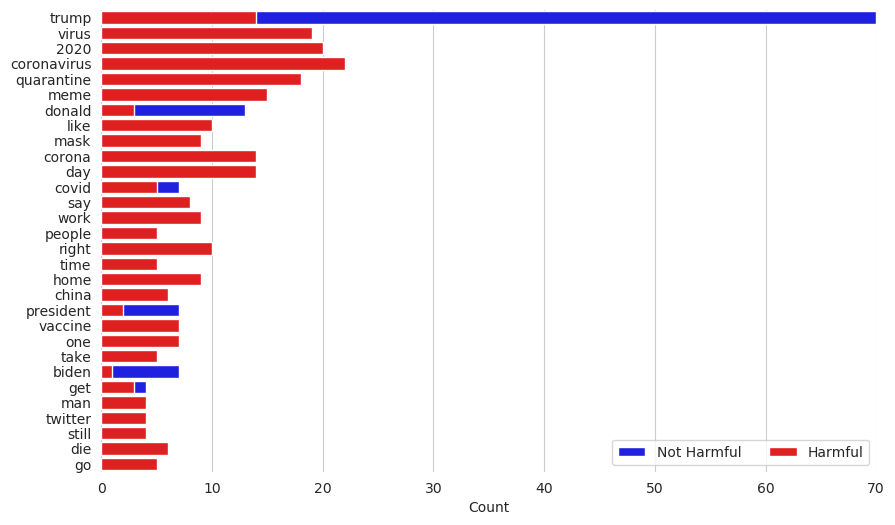

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Plot the 'Not Harmful' counts
sns.barplot(x="Not Harmful", y="word", data=harmful_count, label="Not Harmful", color="blue")

# Plot the 'Harmful' counts on top of the 'Not Harmful' counts
sns.barplot(x="Harmful", y="word", data=harmful_count, label="Harmful", color="red")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, max(harmful_count['Not Harmful'].max(), harmful_count['Harmful'].max())), ylabel="", xlabel="Count")
sns.despine(left=True, bottom=True)

# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.show()

plt.savefig("plots/RandomForest-LimeTop20Words.jpeg")